In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

np.random.seed(42)

In [15]:
@dataclass
class BernoulliBanditEnv:  #Assuming each arm is new advertisment and we have unknown CTR (New ADs)
    def __init__(self, ctrs: np.ndarray):
        self.ctrs = np.array(ctrs, dtype=float)
        self.n_arms = len(self.ctrs)

    def pull(self, arm: int) -> int:
        return int(np.random.rand() < self.ctrs[arm])


In [16]:
true_ctrs = np.array([0.03, 0.05, 0.07, 0.09, 0.11, 0.15])
env = BernoulliBanditEnv(ctrs=true_ctrs)

env.ctrs, env.n_arms, env.ctrs.max()

(array([0.03, 0.05, 0.07, 0.09, 0.11, 0.15]), 6, np.float64(0.15))

### Defining Bandit Policies
- using epsilon-greedy method
- UCB1
- Thompson Sampling

##### E-greedy Method

- Exploring with prob E
- Picking a random ad
- Exploiting with prob 1-E
- pick best preforming ad based on highest avg reward

In [17]:
class EpsilonGreedyBandit:
    def __init__(self, n_arms: int, epsilon: float = 0.1):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.count = np.zeros(n_arms, dtype=int)
        self.sum_rewards = np.zeros(n_arms, dtype=float)

    def select_arm(self, t: int) -> int:
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_arms)
        means = np.divide(self.sum_rewards, np.maximum(self.count, 1))
        return int(np.argmax(means))

    def update(self, arm: int, reward: int) -> None:
        self.count[arm] += 1
        self.sum_rewards[arm] += reward

##### UCB1 
Here in Upper conifidence bound method we select the following:
   - Few impressions ==> more uncertainity and hence mpre exploration
   - More impressions ==> more ceratinity hence more exploitation

In [18]:
class UCB1Bandit:
    def __init__(self, n_arms: int):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms, dtype=int)
        self.sum_rewards = np.zeros(n_arms, dtype=float)

    def select_arm(self, t: int) -> int:
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
        means = self.sum_rewards / self.counts
        confidence = np.sqrt(2 * np.log(t + 1) / self.counts)
        ucb_scores = means + confidence
        return int(np.argmax(ucb_scores))

    def update(self, arm: int, reward: int) -> None:
        self.counts[arm] += 1
        self.sum_rewards[arm] += reward

##### Thompson Sampling
every ad here will maintain a Beta distribution
   - If an ad is uncertain, its distribution is wide → samples vary →  exploration.
   - If an ad is confident and good, samples are consistently high → exploited.

In [19]:
class ThompsonSamplingBandit:
    def __init__(self, n_arms: int, alpha_prior: float = 1.0, beta_prior: float = 1.0):
        self.n_arms = n_arms
        self.alphas = np.ones(n_arms) * alpha_prior
        self.betas = np.ones(n_arms) * beta_prior

    def select_arm(self, t: int) -> int:
        samples = np.random.beta(self.alphas, self.betas)
        return int(np.argmax(samples))

    def update(self, arm: int, reward: int) -> None:
        if reward == 1:
            self.alphas[arm] += 1
        else:
            self.betas[arm] += 1

In [20]:
def run_bandit(env: BernoulliBanditEnv, policy, n_rounds: int = 50_000):
    chosen_arms = np.zeros(n_rounds, dtype=int)
    rewards = np.zeros(n_rounds, dtype=int)
    optimal_arm = int(np.argmax(env.ctrs))
    optimal_ctr = env.ctrs[optimal_arm]
    cumulative_reward = 0
    cumulative_optimal = 0

    cum_reward_list = []
    cum_regret_list = []
    running_ctr_list = []

    for t in range(n_rounds):
        arm = policy.select_arm(t)
        reward = env.pull(arm)
        policy.update(arm, reward)

        chosen_arms[t] = arm
        rewards[t] = reward

        cumulative_reward += reward
        cumulative_optimal += optimal_ctr
        regret = cumulative_optimal - cumulative_reward

        cum_reward_list.append(cumulative_reward)
        cum_regret_list.append(regret)
        running_ctr_list.append(cumulative_reward / (t + 1))

    result = {
        "chosen_arms": chosen_arms,
        "rewards": rewards,
        "cumulative_reward": np.array(cum_reward_list),
        "cumulative_regret": np.array(cum_regret_list),
        "running_ctr": np.array(running_ctr_list),
        "optimal_ctr": optimal_ctr,
        "optimal_arm": optimal_arm,
    }
    return result

In [21]:
N_ROUNDS = 50_000

eps_bandit = EpsilonGreedyBandit(env.n_arms, epsilon=0.1)
ucb_bandit = UCB1Bandit(env.n_arms)
ts_bandit = ThompsonSamplingBandit(env.n_arms)

results_eps = run_bandit(env, eps_bandit, n_rounds=N_ROUNDS)
results_ucb = run_bandit(env, ucb_bandit, n_rounds=N_ROUNDS)
results_ts = run_bandit(env, ts_bandit, n_rounds=N_ROUNDS)

##### Running CTR

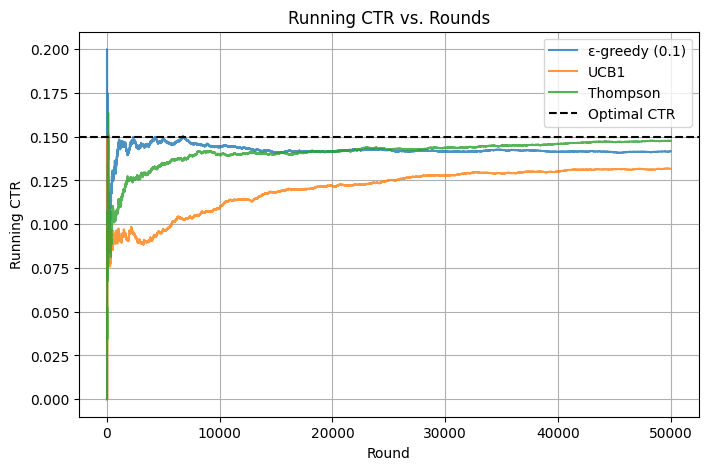

In [22]:
plt.figure()
plt.plot(results_eps["running_ctr"], label="ε-greedy (0.1)", alpha=0.8)
plt.plot(results_ucb["running_ctr"], label="UCB1", alpha=0.8)
plt.plot(results_ts["running_ctr"], label="Thompson", alpha=0.8)
plt.axhline(results_eps["optimal_ctr"], color="black", linestyle="--", label="Optimal CTR")

plt.xlabel("Round")
plt.ylabel("Running CTR")
plt.title("Running CTR vs. Rounds")
plt.legend()
plt.show()

##### Cumulative Regret

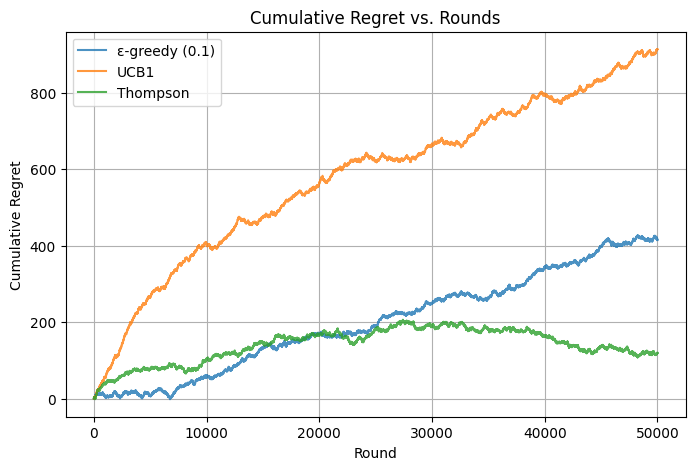

In [23]:
plt.figure()
plt.plot(results_eps["cumulative_regret"], label="ε-greedy (0.1)", alpha=0.8)
plt.plot(results_ucb["cumulative_regret"], label="UCB1", alpha=0.8)
plt.plot(results_ts["cumulative_regret"], label="Thompson", alpha=0.8)

plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret vs. Rounds")
plt.legend()
plt.show()

In [24]:
def summarize(name, res):
    total_reward = res["cumulative_reward"][-1]
    avg_ctr = res["running_ctr"][-1]
    final_regret = res["cumulative_regret"][-1]
    return {
        "policy": name,
        "total_clicks": int(total_reward),
        "avg_ctr": avg_ctr,
        "final_regret": final_regret,
    }

summary_df = pd.DataFrame([
    summarize("epsilon_greedy", results_eps),
    summarize("ucb1", results_ucb),
    summarize("thompson", results_ts),
])

summary_df

,policy,total_clicks,avg_ctr,final_regret
0,epsilon_greedy,7085,0.14170,415.0
1,ucb1,6586,0.13172,914.0
2,thompson,7380,0.14760,120.0
